In [20]:
import morePVs_output as opm
import morePVs as mpv
import os
import en_utilities as um
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

Plotting Total Building Costs
-----------------------------------


Repeating barchart plot from APSRC 2017 paper
1) for EN
2) for btm
For range of:
* PV sizes
* external tariffs and amortization periods

A) Repeat plot, replot for other parameters

B) Plot bau, en, en and pv for range of pvs for each site
   x different tariffs and terms
   x with / without parent FiT
   
   
 


In [21]:


project='EN1_rerun'
study_name='value11'
base_path='C:\\Users\\z5044992\\Documents\\MainDATA\\DATA_EN_4\\studies'
op = opm.Output(base_path = base_path,
                          project = project,
                          study_name = study_name)

In [22]:
self = op
df = self.data.copy()
df_in = self.study_parameters.copy()


df = df.merge(df_in,left_index = True, right_index=True)
for c in df.columns:
    if '_x' in c:
        nc = c[:-2]
        df.rename(columns={c:nc}, inplace=True)


In [23]:
# Set up constants
sites = ['A','E',  'D','B', 'H', 'I', 'G', 'C',  'J', 'F' ]
values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
ordered_sites = dict(zip(sites,values))
tag_list =['a208_f12_cp34',
 'a161_f7_cp38',
 'a138_f9_cp44',
 'a104_f8_cp57',
 'a52_f3_cp26',
 'a48_f4_cp09',
 'a44_f4_cp17',
 'a34_f4_cp33',
 'a26_f4_cp43',
 'a20_f5_cp36']
tag_sorter= dict(zip(tag_list,values))
tag_dict = dict(zip(sites,tag_list))


# Plotting set-up parameters
cmap = mpl.cm.tab10
alpha=1
markers =['x','o','D','*','^','H','s','v','>','<']
site_markers = dict(zip(sites,markers))
colours = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
site_colours = dict(zip(sites,colours))
# get pv sizes for maximum pv systems
maximums={}
pv_ref_file='C:\\Users\\z5044992\\Documents\\MainDATA\\DATA_EN_4\\reference\\capex_pv_lookup.csv'
pv_ref=pd.read_csv(pv_ref_file)
pv_ref = pv_ref.set_index('pv_cap_id')
for i in pv_ref.index:
    if 'max' in i and 'site' in i:
        site = um.find_between(i,'_','_')
        maximums[site] = pv_ref.loc[i,'kW']
en_capexes= ['capex_low','capex_med','capex_high']
# parents = ['EA310_12c_FIT8', 'EA310_12c_FIT12', 'EA310_12c',
#            'EA310_10c_FIT8', 'EA310_10c_FIT12', 'EA310_10c',
#          'EA310_8c_FIT8', 'EA310_8c_FIT12','EA310_8c']
a_rates =[5,10,15,20,25]

In [24]:
df['site'] = df['load_folder'].str[-1]
df['site_tag'] = df['site'].apply(lambda x: tag_dict[x])

In [25]:
# get kWp / unit and total $ / unit for each scenario
df['pv_filename'].fillna('zero',inplace=True)
for s in df.index:
    site = df.loc[s,'load_folder'][-1]
    df.loc[s,'site']=site
    if df.loc[s,'pv_filename'] == 'zero':
        df.loc[s,'kwp_unit'] =0
    elif 'max' in df.loc[s,'pv_filename']:
        df.loc[s,'kwp_unit']= maximums[site]/df.loc[s,'number_of_households']
    else:
        df.loc[s,'kwp_unit'] = float(df.loc[s,'pv_filename'][-9]) + float(df.loc[s,'pv_filename'][-7])/10
    df.loc[s,'$_unit'] = df.loc[s,'total$_building_costs_mean']/df.loc[s,'number_of_households']

    
        

In [26]:
# Sort sites in correct order (decreasing number apartments)
df['site_order']= df['site'].apply(lambda x: ordered_sites[x])
df.sort_values(by='site_order', inplace=True)

In [27]:
# For Maxbarchart, first use single set of parameters with max PV
capex= 'capex_med'
#1) Max PV for Site

tariff = 'EASO_TOU_15pc_FIT8'
bau_tariffs = ['EASO_TOU_15pc_FIT8','EASO_TOU_15pc','EASO_TOU_15pc_FIT12']
parent_retail = 'TOU12_FIT8'  
a_term = 20 

sites = sites

arrangements = ['bau', 'cp_only','btm_i_c',  'btm_s_c', 'en', 'en_pv'  ]
arr_values = [i for i in range(1,6)]
arr_sorter= dict(zip(arrangements, arr_values))
dfx= df.copy()
dfbau = dfx.loc[(dfx['arrangement'] == 'bau') & (dfx['all_residents'].str.contains(tariff[0:12]) )
                & (dfx['a_term'] == a_term)]

dfcp = dfx.loc[(dfx['arrangement'] == 'cp_only') & (dfx['all_residents'] == tariff) &
              (dfx['a_term'] == a_term) & (dfx['pv_filename'].str.contains('max'))]


dfbtmi = dfx.loc[(dfx['arrangement'] == 'btm_i_u') & (dfx['all_residents'] == tariff) &
              (dfx['a_term'] == a_term) & (dfx['pv_filename'].str.contains('max'))]

dfbtmicp = dfx.loc[(dfx['arrangement'] == 'btm_i_c') & (dfx['all_residents'] == tariff) &
              (dfx['a_term'] == a_term) & (dfx['pv_filename'].str.contains('max'))]


if 'FIT' in parent_retail:
    dfen = dfx.loc[(dfx['arrangement'] == 'en') & (dfx['parent'].str.contains(parent_retail))  &
                  (dfx['a_term'] == a_term) & (dfx['en_capex_id'] == capex)] 
    dfenp = dfx.loc[(dfx['arrangement'] == 'en_pv') & (dfx['parent'].str.contains(parent_retail))  &
                  (dfx['a_term'] == a_term) & (dfx['pv_filename'].str.contains('max')) &
                  (dfx['en_capex_id'] == capex)]
else:
    dfen = dfx.loc[(dfx['arrangement'] == 'en') & (dfx['parent'].str.contains(parent_retail))  &
                  (dfx['a_term'] == a_term) & (dfx['en_capex_id'] == capex)& ~(dfx['parent'].str.contains('FIT'))]
    dfenp = dfx.loc[(dfx['arrangement'] == 'en_pv') & (dfx['parent'].str.contains(parent_retail))  &
                  (dfx['a_term'] == a_term) & (dfx['pv_filename'].str.contains('max')) &
                  (dfx['en_capex_id'] == capex) & ~(dfx['parent'].str.contains('FIT'))]


dfbtmsu = dfx.loc[(dfx['arrangement'] == 'btm_s_u') & (dfx['all_residents'] == tariff) &
              (dfx['a_term'] == a_term) & (dfx['pv_filename'].str.contains('max'))& (dfx['en_capex_id'] == 'upfront_1')]

dfbtmsc = dfx.loc[(dfx['arrangement'] == 'btm_s_c') & (dfx['all_residents'] == tariff) &
              (dfx['a_term'] == a_term) & (dfx['pv_filename'].str.contains('max'))& (dfx['en_capex_id'] == 'upfront_1')]

dfbtmpu = dfx.loc[(dfx['arrangement'] == 'btm_p_u') & (dfx['all_residents'] == 'SIT_15_ppa1') &
              (dfx['a_term'] == a_term) & (dfx['pv_filename'].str.contains('max'))& 
              (dfx['en_capex_id'] == 'ppa_1')]

dfbtmpc = dfx.loc[(dfx['arrangement'] == 'btm_p_c') & (dfx['all_residents'] == 'SIT_15_ppa1') &
              (dfx['a_term'] == a_term) & (dfx['pv_filename'].str.contains('max'))& 
              (dfx['en_capex_id'] == 'ppa_1')]

# df4 = dfx.loc[(dfx['arrangement'] == 'en_pv') & (dfx['parent'].str.contains(parent_retail)) & ~(dfx['parent'].str.contains('FIT')) &
#               (dfx['a_term'] == a_term) & (dfx['pv_filename'].str.contains('max')) & (dfx['en_capex_id'] == capex)]
# df5 = dfx.loc[(dfx['arrangement'] == 'en') & (dfx['parent'].str.contains(parent_retail)) & ~(dfx['parent'].str.contains('FIT')) &
#               (dfx['a_term'] == a_term) & (dfx['en_capex_id'] == capex)]
              
dfallmax = dfbau.append([dfcp,dfbtmicp,dfbtmsc,dfen,dfenp])     

In [28]:
# For barchart, use single set of parameters with 1kWp/unit
capex= 'capex_med'

#2)
kWp_per_unit = 1.0



dfx= df.copy()
dfbau = dfx.loc[(dfx['arrangement'] == 'bau') & (dfx['all_residents'].str.contains(tariff[0:12]) )
               & (dfx['a_term'] == a_term)]

dfcp = dfx.loc[(dfx['arrangement'] == 'cp_only') & (dfx['all_residents'] == tariff) &
              (dfx['a_term'] == a_term) &
              (dfx['kwp_unit'] > 0.95) & (dfx['kwp_unit'] < 1.05) ]

dfbtmicp  = dfx.loc[(dfx['arrangement'] == 'btm_i_c') & (dfx['all_residents'] == tariff) &
              (dfx['a_term'] == a_term) &
              (dfx['kwp_unit'] > 0.95) & (dfx['kwp_unit'] < 1.05) ]

dfbtmsc = dfx.loc[(dfx['arrangement'] == 'btm_s_c') & (dfx['all_residents'] == tariff) &
              (dfx['a_term'] == a_term) & (dfx['kwp_unit'] > 0.95) & (dfx['kwp_unit'] < 1.05) & 
              (dfx['en_capex_id'] == 'upfront_1')]

if 'FIT' in parent_retail:
    dfen = dfx.loc[(dfx['arrangement'] == 'en') & (dfx['parent'].str.contains(parent_retail))  &
                  (dfx['a_term'] == a_term) & (dfx['en_capex_id'] == capex)]

    dfenp = dfx.loc[(dfx['arrangement'] == 'en_pv') & (dfx['parent'].str.contains(parent_retail))  &
                  (dfx['a_term'] == a_term) & (dfx['kwp_unit'] > 0.95) & (dfx['kwp_unit'] < 1.05) &
                  (dfx['en_capex_id'] == capex)]
else:
    dfen = dfx.loc[(dfx['arrangement'] == 'en') & (dfx['parent'].str.contains(parent_retail))  &
                  (dfx['a_term'] == a_term) & (dfx['en_capex_id'] == capex) &
                   ~(dfx['parent'].str.contains('FIT'))]

    dfenp = dfx.loc[(dfx['arrangement'] == 'en_pv') & (dfx['parent'].str.contains(parent_retail))  &
                  (dfx['a_term'] == a_term) & (dfx['kwp_unit'] > 0.95) & (dfx['kwp_unit'] < 1.05) &
                  (dfx['en_capex_id'] == capex)&
                   ~(dfx['parent'].str.contains('FIT'))]



dfbtmsu = dfx.loc[(dfx['arrangement'] == 'btm_s_u') & (dfx['all_residents'] == tariff) &
              (dfx['a_term'] == a_term) &  (dfx['kwp_unit'] > 0.95) & (dfx['kwp_unit'] < 1.05) & 
              (dfx['en_capex_id'] == 'upfront_1')]

dfbtmsc = dfx.loc[(dfx['arrangement'] == 'btm_s_c') & (dfx['all_residents'] == tariff) &
              (dfx['a_term'] == a_term) &  (dfx['kwp_unit'] > 0.95) & (dfx['kwp_unit'] < 1.05) & 
               (dfx['en_capex_id'] == 'upfront_1')]

dfbtmpu = dfx.loc[(dfx['arrangement'] == 'btm_p_u') & (dfx['all_residents'] == 'SIT_15_ppa1') &
              (dfx['a_term'] == a_term) &  (dfx['kwp_unit'] > 0.95) & (dfx['kwp_unit'] < 1.05) &
              (dfx['en_capex_id'] == 'ppa_1')]

dfbtmpc = dfx.loc[(dfx['arrangement'] == 'btm_p_c') & (dfx['all_residents'] == 'SIT_15_ppa1') &
              (dfx['a_term'] == a_term) &  (dfx['kwp_unit'] > 0.95) & (dfx['kwp_unit'] < 1.05) & 
              (dfx['en_capex_id'] == 'ppa_1')]

              
dfall1 = dfbau.append([dfcp,dfbtmicp,dfbtmsc,dfen,dfenp])    

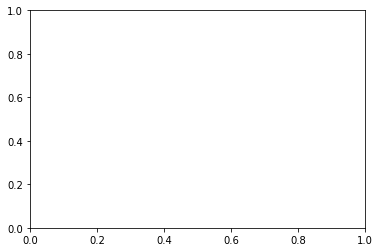

In [31]:



# Plot Max PV for all Sites
# -------------------------

dfx= dfallmax.copy()

dfx['tag_order'] = dfx['site_tag'].map(tag_sorter)
dfx['arr_order']= dfx['arrangement'].map(arr_sorter)

# ----------------------
# reindex and stack data
# ----------------------
dfx.index = [dfx.site_tag,dfx.arrangement]
dfu = dfx['$_unit'].unstack()
# --------------------
# Sort into tag order
# --------------------
dfu['tag']=dfu.index
dfu['order'] = dfu.tag.apply(lambda x: tag_sorter[x])
dfu.sort_values('order', ascending = True, inplace=True)
dfu.drop(['order','tag'],axis=1,inplace=True)
# -----------------------------
# Sort into arrangement order
# ----------------------------
dfu = dfu[arrangements]


# Plotting set-up parameters
cmap = mpl.cm.tab10_r
alpha=1

fig, ax = plt.subplots()
ax = dfu.plot(kind='bar',width = 0.8,figsize=(15,12), fontsize=20, legend=False)

ax.set_ylabel("Total Site Costs ($/unit)", fontsize=20)
ax.set_xlabel("")
#ax.set_title ("Maximum PV ",fontsize=24)
#ax.legend(fontsize=20, loc='upper left', bbox_to_anchor=(1, 0.8))
#Legends outside box and resize chart to fit
# box = ax.get_position()
# ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
text0='BAU / BTM retail tariff: ' + tariff 
text1='EN Parent retail tariff: ' + parent_retail
text2 = 'EN Capex: '+ capex
text3 = 'Amortisation: '+str(a_term) + ' years'
text4 = 'PV: Maximum Roof Capacity'
ax.text(4,2400, text0, fontsize=20)
ax.text(4,2300,text1, fontsize=20)
ax.text(4,2200,text2, fontsize=20)
ax.text(4,2100,text3, fontsize=20)
ax.text(4,1900,text4, fontsize=20)

ax.grid(True)
ax.set_ylim((0,2500))
ax.set_xticklabels(dfu.index,rotation=40, ha='right', fontsize =20)
plt.tight_layout() # To ensure labels fit in bounding box
#fig.show()
pname = 'bar_' + study_name +'btmen_maxpv2_' +parent_retail+ '_'+str(a_term)+'.jpg'
plotFile = os.path.join(self.plot_path,pname)
plt.savefig(plotFile,dpi=1000)
plt.close()




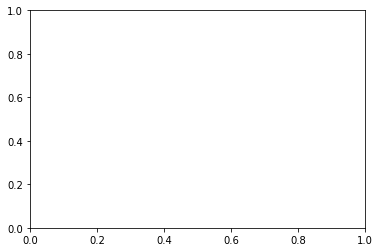

In [32]:
# Plot 1kW / unit for subset of sites
# -----------------------------------
# Drop sites with no PV = 1kW/unit options:
dfx= dfall1.copy()
dfx['tag_order'] = dfx['site_tag'].map(tag_sorter)
dfx['arr_order']= dfx['arrangement'].map(arr_sorter)

dfx.sort_values(['tag_order','arr_order'], ascending = [True,True] ,inplace=True)
tags = df['site_tag'].drop_duplicates().tolist()
for tag in tags:
    if len(dfx.loc[(dfx['site_tag'] ==tag) & (dfx['arrangement']=='btm_s_c')])==0:
        dfx = dfx[dfx.site_tag != tag]
        
        
dfx['tag_order'] = dfx['site_tag'].map(tag_sorter)
dfx['arr_order']= dfx['arrangement'].map(arr_sorter)
# dfx.sort_values(['tag_order','arr_order'], ascending = [True,True] ,inplace=True)

# ----------------------
# reindex and stack data
# ----------------------
dfx.index = [dfx.site_tag,dfx.arrangement]
dfu = dfx['$_unit'].unstack()
# --------------------
# Sort into tag order
# --------------------
dfu['tag']=dfu.index
dfu['order'] = dfu.tag.apply(lambda x: tag_sorter[x])
dfu.sort_values('order', ascending = True, inplace=True)
dfu.drop(['order','tag'],axis=1,inplace=True)
# -----------------------------
# Sort into arrangement order
# ----------------------------
dfu = dfu[arrangements]

fig, ax = plt.subplots()
ax = dfu.plot(kind='bar',width = 0.8,figsize=(7.5,12), fontsize=20)
ax.set_xlabel("")
ax.set_ylabel("Total Site Costs ($/unit)", fontsize=20)
#ax.set_title ("PV 1kWp per Unit",fontsize=24)
ax.legend(fontsize=20,loc='upper left', bbox_to_anchor=(0,1))
ax.set_xticklabels(dfu.index,rotation=40, ha='right', fontsize =20)

text4 = 'PV: 1.0 kWp / unit'
ax.text(1.5,1900,text4, fontsize=20)

plt.tight_layout() # To ensure labels fit in bounding box
ax.grid(True)
ax.set_ylim((0,2500))
#fig.show()
pname = 'bar_' + study_name +'_btm_en2_1kW_' +parent_retail+ '_'+str(a_term)+'.jpg'
plotFile = os.path.join(self.plot_path,pname)
plt.savefig(plotFile,dpi=1000)
plt.close()


In [12]:
plotFile


'C:\\Users\\z5044992\\Documents\\MainDATA\\DATA_EN_4\\studies\\EN1_rerun\\outputs\\value11\\plots\\bar_value11_btm_en2_1kW_TOU12_FIT8_20.jpg'